In [1]:
%matplotlib inline

# Analyze Nanostring CosMx non-small-cell lung cancer (NSCLC) data
This tutorial shows how to apply Bering to Nanostring CosMx data.

Nanostring CosMx NSCLC {cite}`he2022high` data was generated on eight FFPE non-small cell non cancer tissue samples. The original data can be found in this link: https://nanostring.com/products/cosmx-spatial-molecular-imager/nsclc-ffpe-dataset/. We took one of the filed of view (FOV 10) as an example in this tutorial.

### Import packages & data

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 

import Bering as br

In [3]:
mpl.rcParams['figure.figsize'] = [5, 5]

In [4]:
# load data
df_spots_all = br.datasets.cosmx_nsclc_he()
df_spots_seg = df_spots_all[df_spots_all['labels'] != 'background'] # foreground nodes
df_spots_unseg = df_spots_all[df_spots_all['labels'] == 'background'] # background nodes

img = None 
channels = None

df_spots_seg.head()

,x,y,z,features,segmented,components,fov,labels
13342297,347.82858,48.571430,4,S100P,1,Cytoplasm,10,tumor
13342298,325.10000,42.125000,4,RAC1,1,Membrane,10,tumor
13342299,344.16248,43.912502,4,ITGB1,1,Cytoplasm,10,tumor
13342300,327.53000,48.960000,4,GSTP1,1,Cytoplasm,10,tumor
13342301,353.96250,19.949999,4,CLDN4,1,Membrane,10,tumor


In [5]:
df_spots_unseg.head() # visualize unsegmented data

,x,y,z,features,segmented,components,fov,labels
13131760,4667.9624,225.46251,4,S100A10,-1,Membrane,10,background
13131761,5063.0000,974.55005,4,FGR,-1,0,10,background
13131762,3770.3710,1280.65720,4,IL4R,-1,0,10,background
13131763,4671.2170,1350.08340,4,S100A10,-1,Membrane,10,background
13131764,2105.9167,2135.41670,4,IGHA1,-1,0,10,background


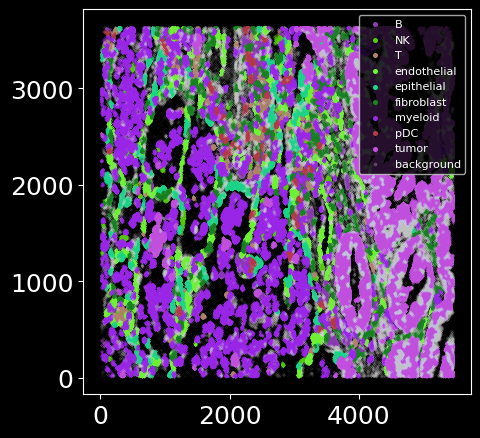

In [6]:
# visualize segmented and unsegmented data
br.pl.Plot_Spots(df_spots_seg = df_spots_seg, df_spots_unseg = df_spots_unseg)

### Create Bering object

In [7]:
# image-free segmentation
bg = br.BrGraph(df_spots_seg, df_spots_unseg, img, channels)
bg

In [8]:
bg.segmented.head() # summary of cells

,cx,cy,cz,dx,dy,dz,d,labels
segmented,,,,,,,,
0,330.050018,36.464283,5.0,78.366302,61.139999,8,78.366302,tumor
1,630.057770,30.633572,4.0,113.074950,53.514284,9,113.074950,endothelial
2,773.127380,35.350002,5.0,61.014648,48.891116,8,61.014648,epithelial
3,1950.387451,21.155557,1.0,59.865234,25.408331,8,59.865234,myeloid
4,2082.986694,23.441666,5.0,60.033447,27.858335,7,60.033447,myeloid


### Create training data

In [9]:
# Build graphs for GCN training purpose
br.graphs.BuildWindowGraphs(
    bg, 
    n_cells_perClass = 8, 
    window_width = 100.0, 
    window_height = 100.0, 
    n_neighbors = 10, 
)

In [10]:
br.graphs.CreateData(
    bg, 
    batch_size = 16, 
    training_ratio = 0.8, 
)

### Training

Training node classifier:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▍| 179/180 [02:31<00:00,  1.42it/s]

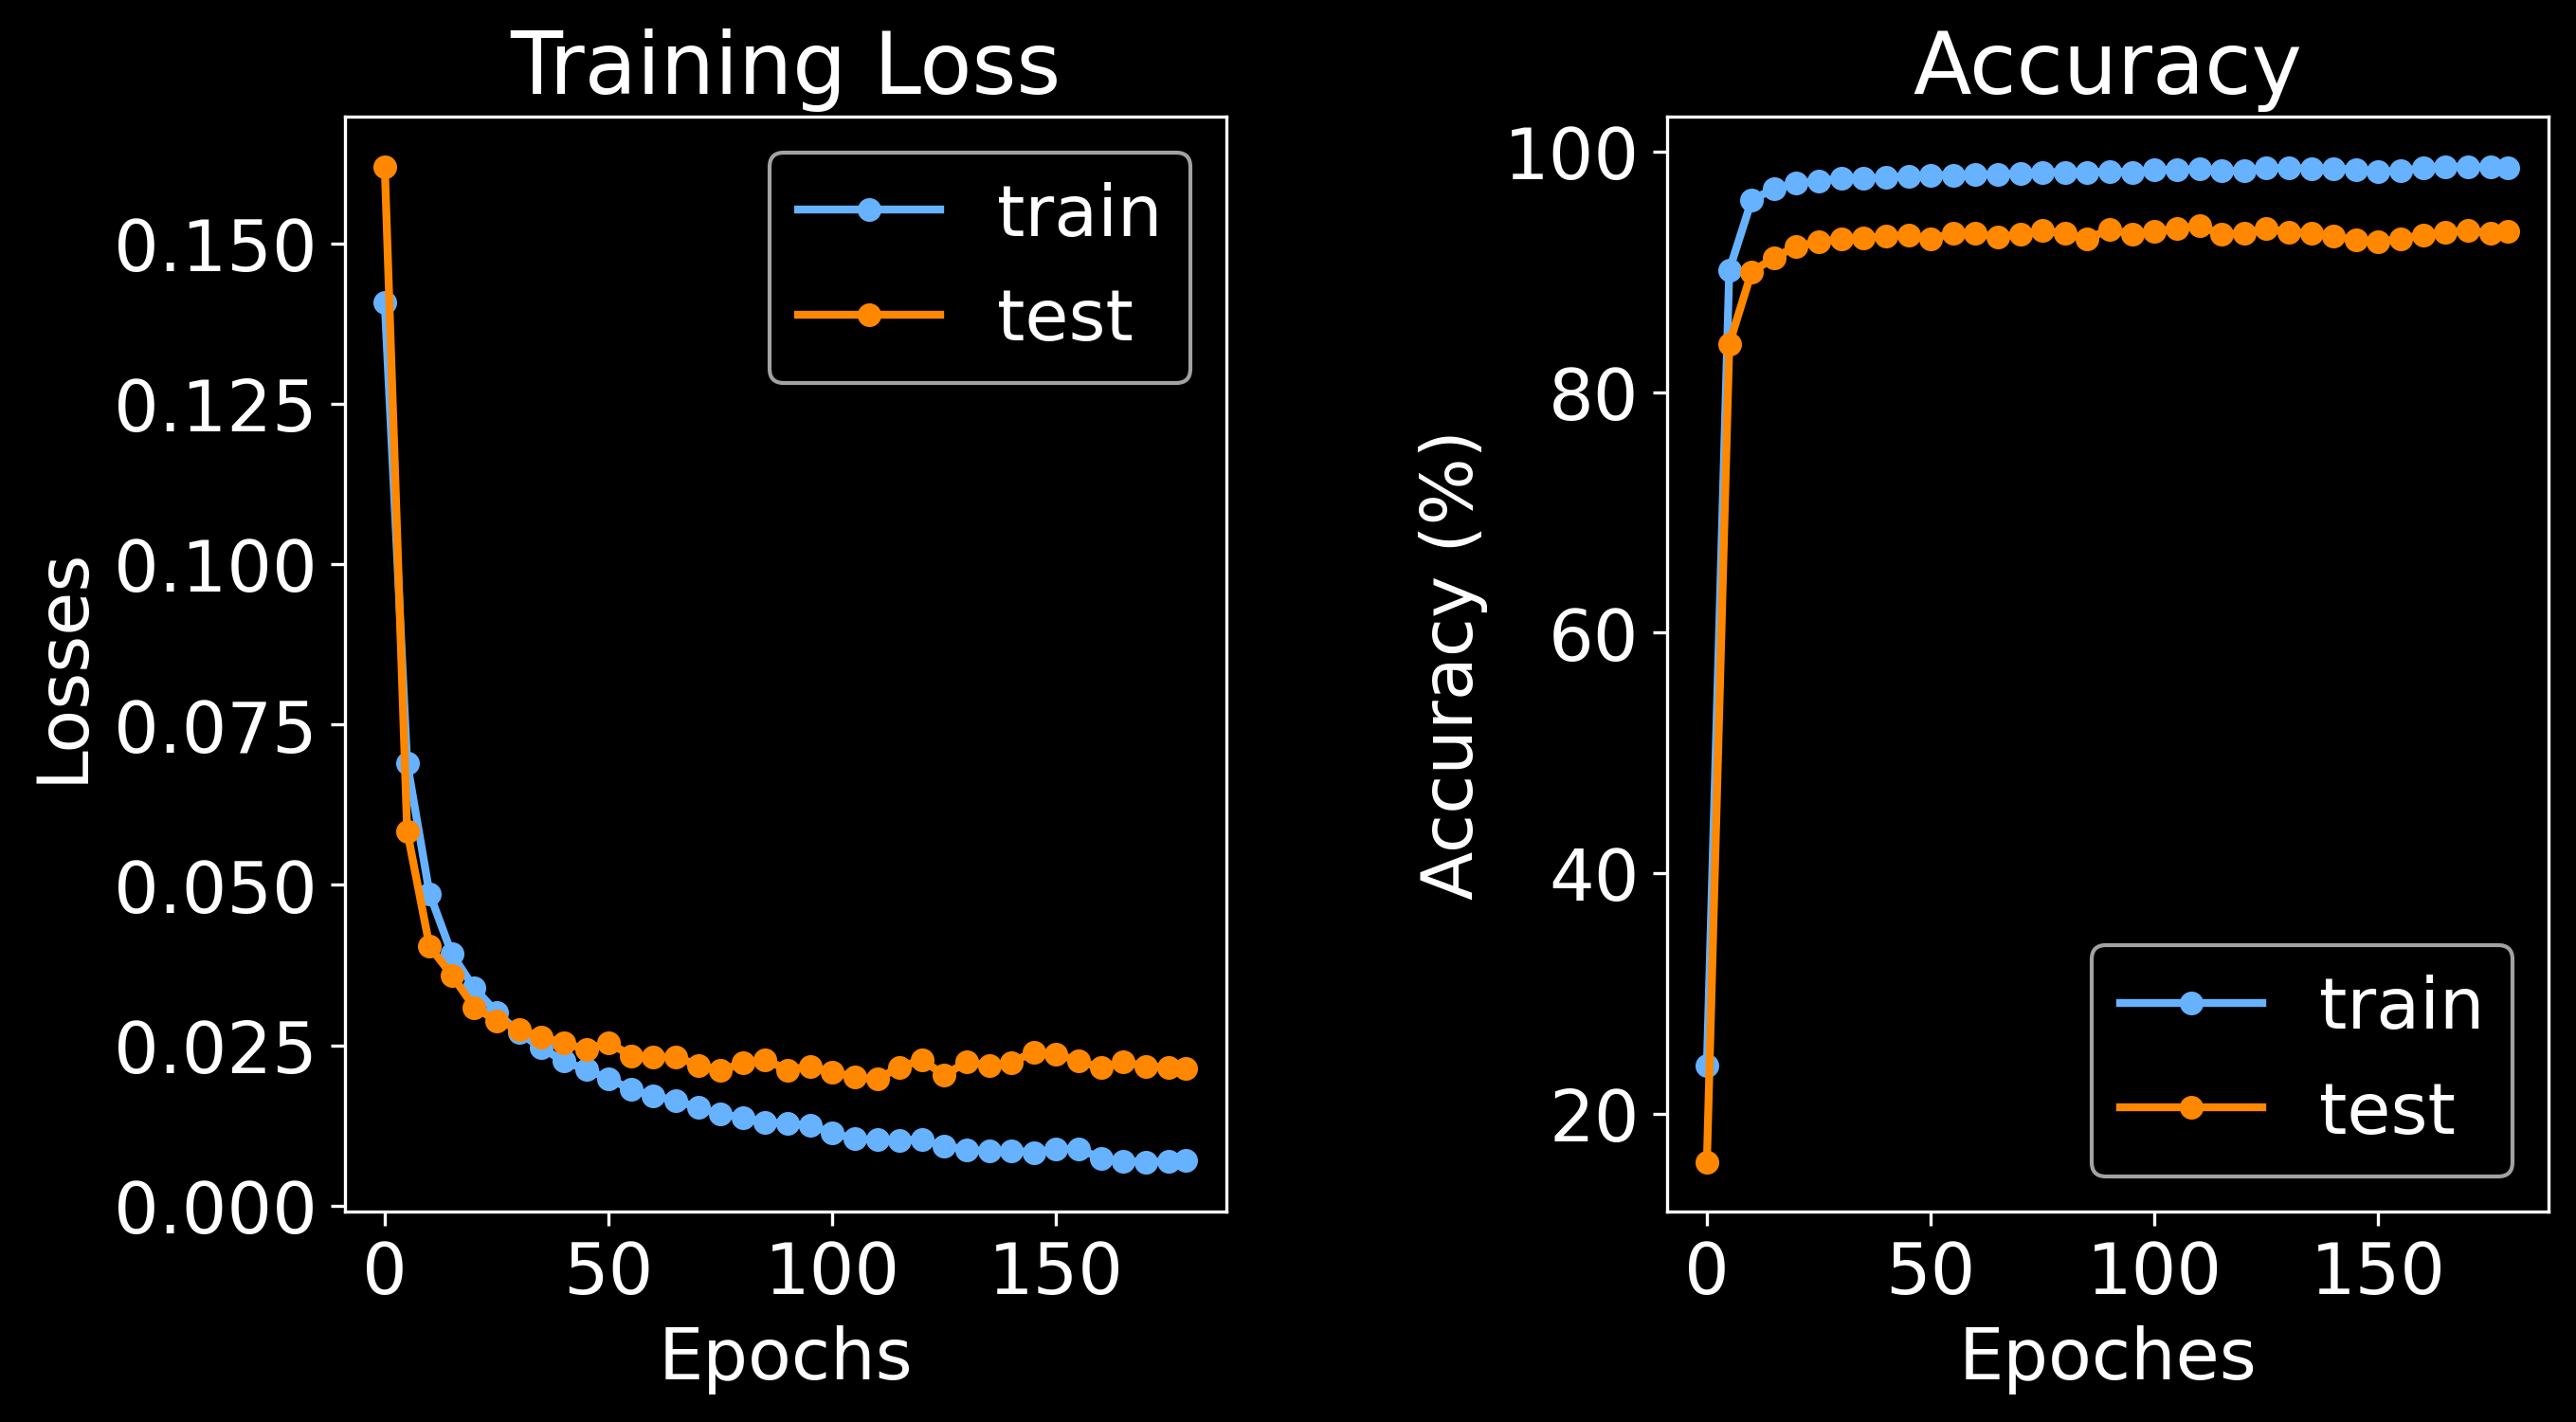

Training edge classifier:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [00:36<00:00,  1.44it/s]

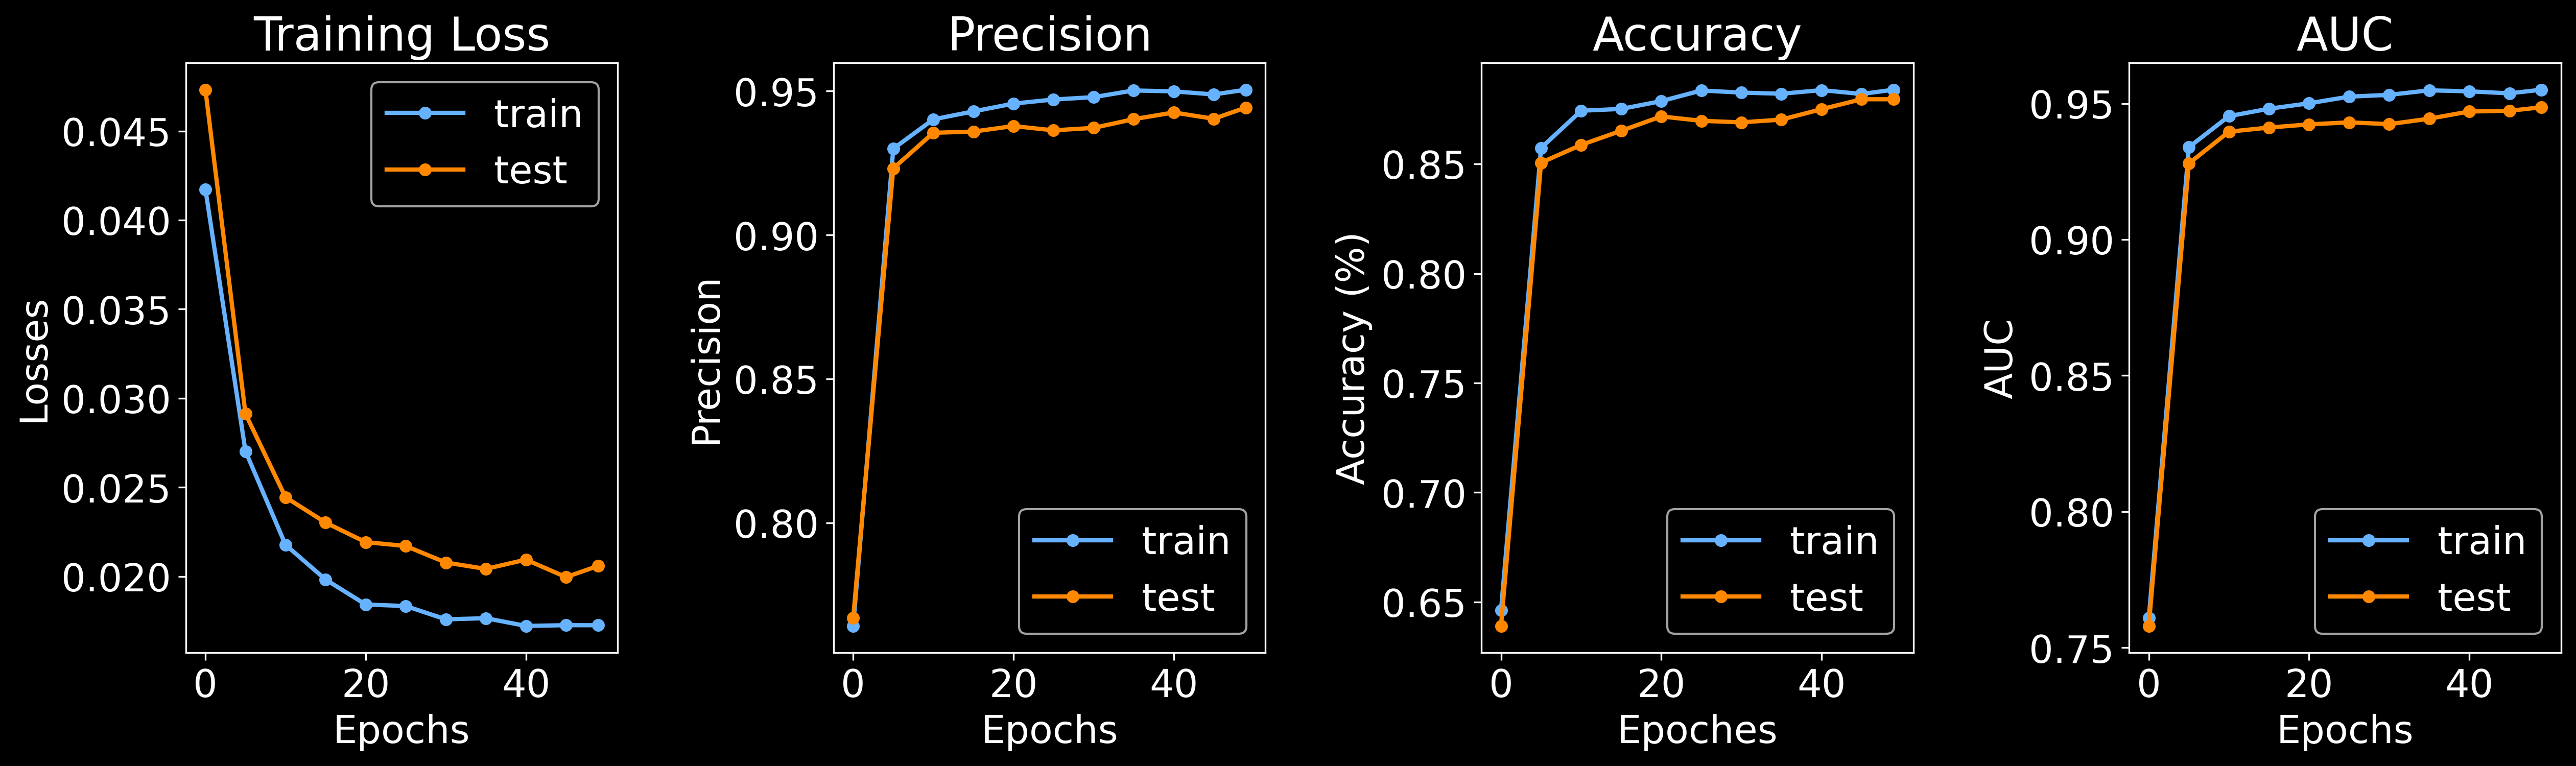

Training edge classifier: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]


In [11]:
br.train.Training(
    bg,
    edge_rbf_stop = 128,
    edge_rbf_n_kernels = 64,
    node_epoches = 180,
)

In [12]:
# save the trained model
import pickle
with open('cosmx_nsclc_he.pkl', 'wb') as f:
    pickle.dump(bg, f)

### Visualizing model

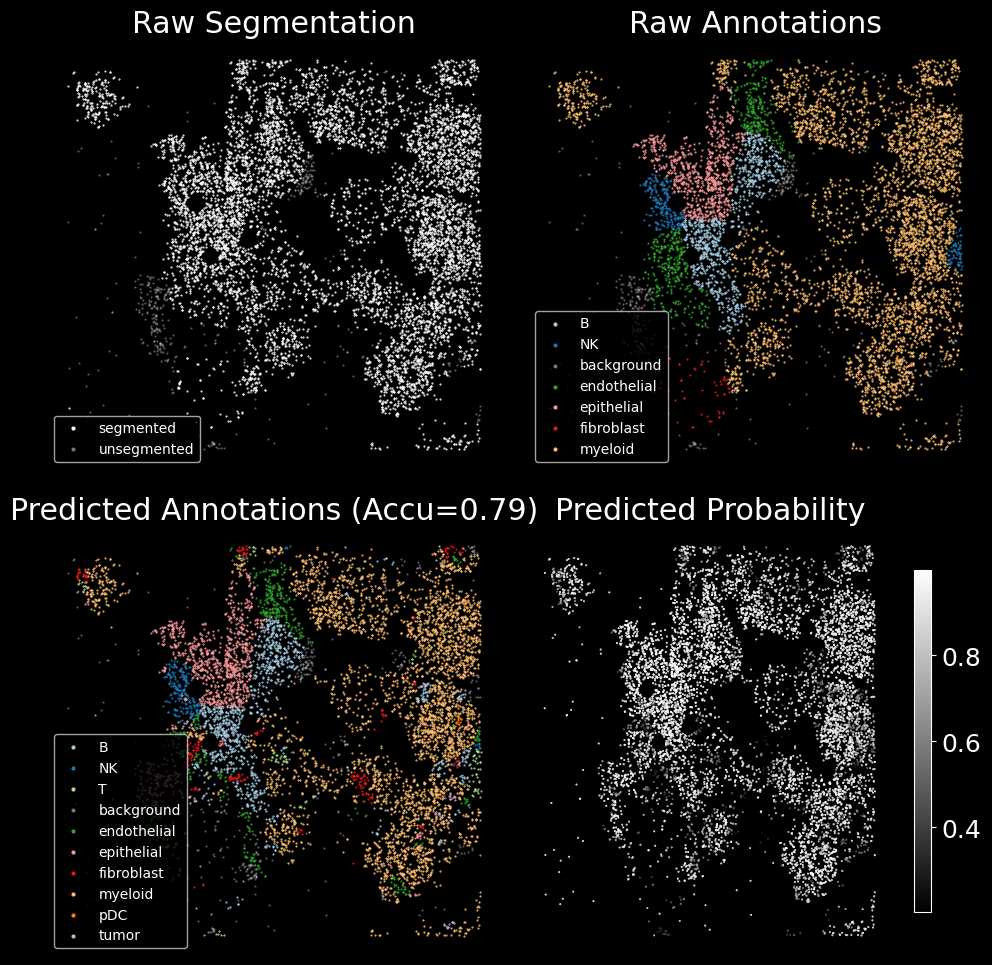

In [13]:
# randomly select a cell
random_cell = cells = random.sample(bg.segmented.index.values.tolist(), 5)[3]

# plot node classification
df_window_raw, df_window_pred, predictions = br.pl.Plot_Classification(
    bg, 
    cell_name = random_cell,
    n_neighbors = 10, 
    zoomout_scale = 4,
)

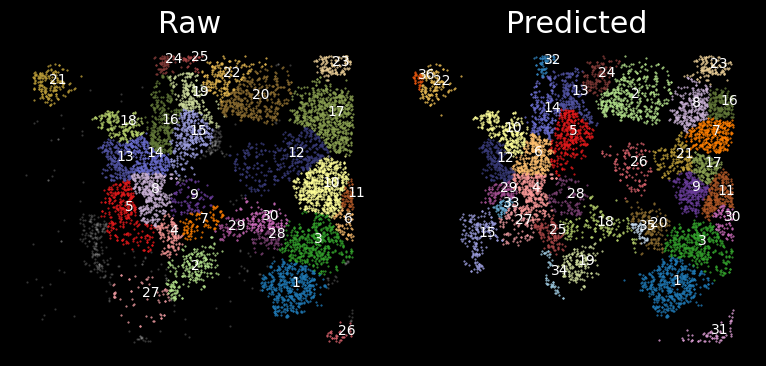

In [14]:
# plot cell segmentation
br.pl.Plot_Segmentation(
    bg, 
    cell_name = random_cell,
    n_neighbors = 10, 
    zoomout_scale = 4,
    use_image = True,
    pos_thresh = 0.6,
    resolution = 0.15,
    num_edges_perSpot = 100,
    min_prob_nodeclf = 0.3,
    n_iters = 20,
)

After the model is trained, we can use the trained model to predict the cell types and segment all spots on the whole slice. After node classification and cell segmentation is completed, we generate single cell matrix in the end.

### Node classification
Conduct node classification on the whole slice.

In [15]:
br.tl.node_classification(
    bg, bg.spots_all.copy(), 
    n_neighbors = 10, 
)
bg.spots_all.to_csv('spots_all.txt', sep = '\t')

### Cell segmentation

In [16]:
br.tl.cell_segmentation(bg)

### Get single cells

In [17]:
df_results, adata_ensembl, adata_segmented = br.tl.cell_annotation(bg)
df_results.to_csv('results.txt', sep = '\t')
adata_ensembl.write('results_cells_ensembled.h5ad')
adata_segmented.write('results_cells_segmented.h5ad')

print(f'Ensembled anndata: {adata_ensembl.shape}')
print(f'Segmented anndata: {adata_segmented.shape}')

... storing 'predicted_labels' as categorical


Ensembled anndata: (741, 980)
Segmented anndata: (1708, 980)


### Single cell data analysis

2023-08-22 14:01:33.701161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 14:01:33.921550: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


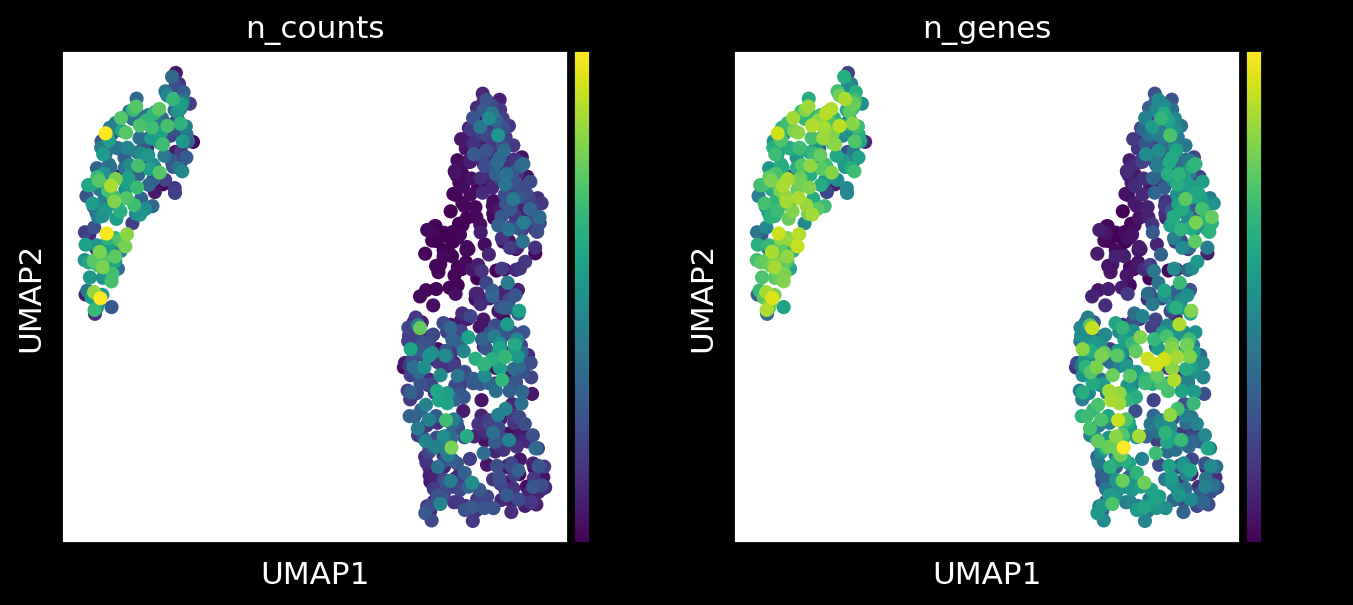

In [18]:
import scanpy as sc
sc.settings.set_figure_params(dpi=80)

# run standard analysis on the ensembled anndata
adata_ensembl = br.tl.cell_analyze(adata_ensembl)

# first check the data quality of segmented cells
sc.pl.umap(adata_ensembl, color = ['n_counts','n_genes'])

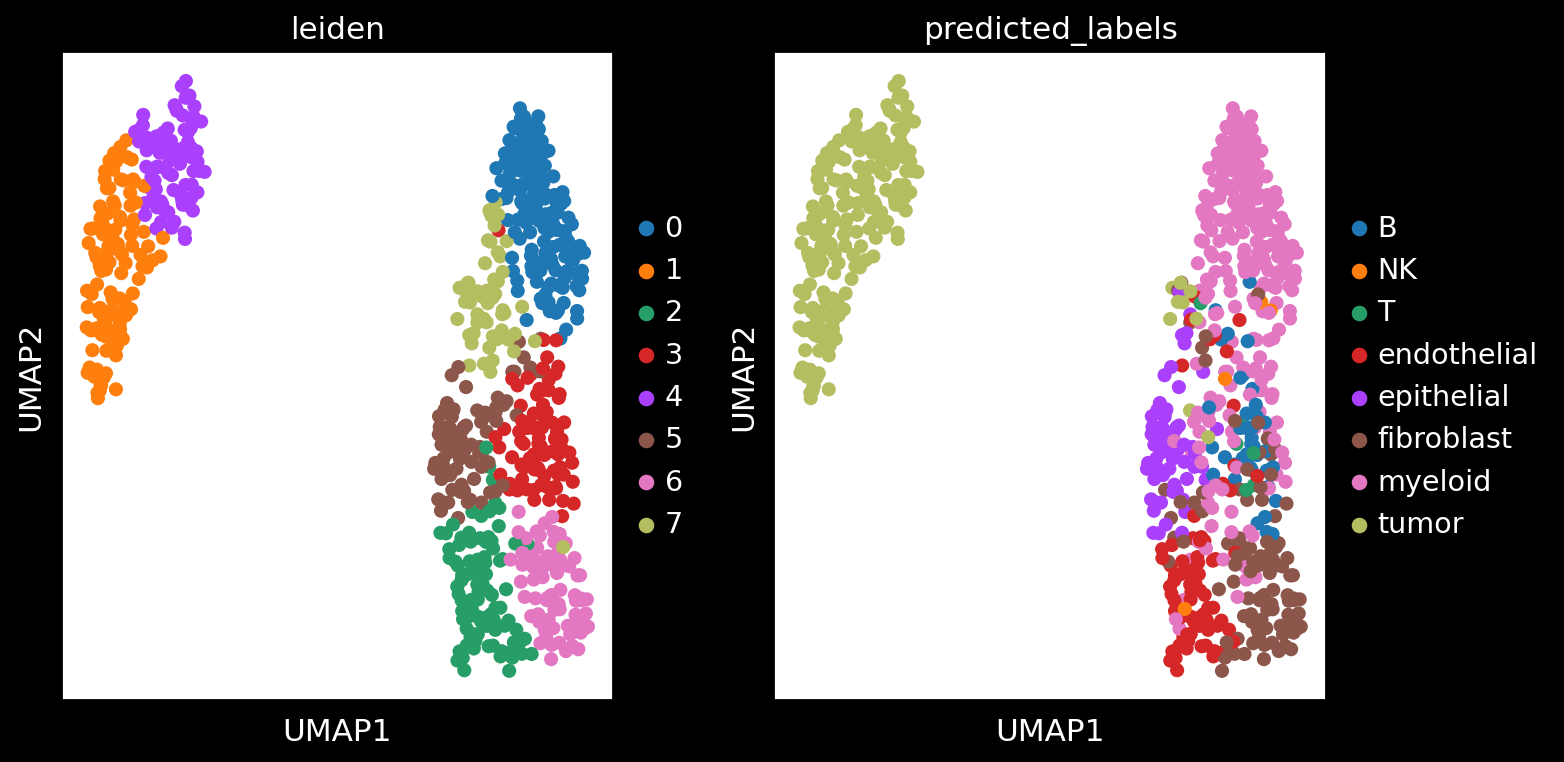

In [19]:
# plot leiden clustering and predicted labels from Bering
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0] = sc.pl.umap(adata_ensembl, color = ['leiden'], ax = axes[0], show = False)
axes[1] = sc.pl.umap(adata_ensembl, color = ['predicted_labels'], ax = axes[1], show = False)

plt.subplots_adjust(wspace = 0.5)
plt.tight_layout()
plt.show()